# Attention is All You Need - Transformer

## Tranformer architecture

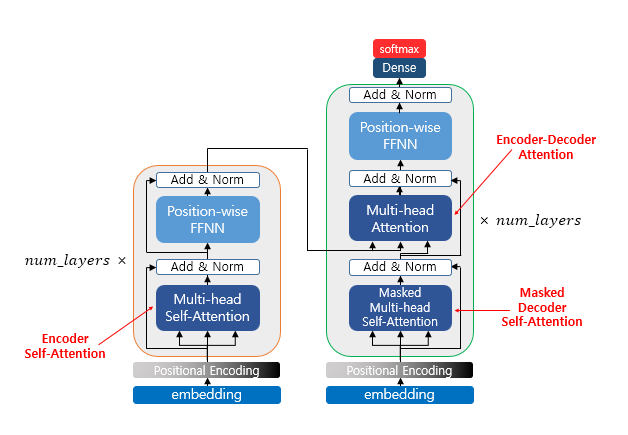


### TransformerEncoderLayer => TransformerEncoder

### d_model = 512, nhead = 8, num_layers = 6
###### d_model : transformer의 encoder와 decorder에서 정해진 입출력 크기
    embedding vector의 차원과 동일 + encoder/decoder 내에서 값이 전달될 때의 차원과 동일
###### nhead : Transformer에서 Attention을 병렬로 연산 처리 후 결과 값을 하나로 합치는 방식
    해당 병렬 개수
###### num_layer : encoder와 decoder를 총 몇 층으로 쌓을지에 대한 하이퍼 파라미터
###### d_hid(dimension_feedforward) : Transformer 내부 feed-forward 신경망의 은닉층의 크기
    d_hid 차원에서 d_model 차원으로 embedding 진행

In [8]:
#TransformerEncoderLayer

#encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
#src = torch.rand(32, 10, 512)

#print(src)

#out = encoder_layer(src)

#out.size()

In [9]:
#TransformerEncoder(encoder_layer, num_layers, norm=None)

#encoder_layer는 TransformerEncoderLayer에서 나온 out 이용
#num_layer는 Encoder를 몇 층으로 쌓을지에 대한 하이퍼파라미터

#encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
#transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
#src = torch.rand(10, 32, 512)
#out = transformer_encoder(src)

#out.size()

torch.Size([10, 32, 512])

In [10]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)                       #positional encoding
        #TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        #TransformerEncoderLayer(512, 8, 2048)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        #nn.Embedding(num_embeddings, embedding_dim)
        #token set의 크기를 10으로 한정 지었기 때문에 k(embedding_dim)의 자리에 10(num_embeddings) 이상의 숫자는 들어올 수 없다.
        
        self.encoder = nn.Embedding(ntoken, d_model)                                  #encoder가 embedding layer
        self.d_model = d_model 
        
        #output이 가장 등장 확률이 높은 단어 하나 => Decoder가 아닌 Linear Layer 한층으로 간소화
        self.decoder = nn.Linear(d_model, ntoken)                                     #decoder가 Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None: #가중치
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src) #positional encoding
        output = self.transformer_encoder(src, src_mask) #TransfomerEncoder
        output = self.decoder(output)
        return output


#self-Attention 과정에서 이전 position의 단어들만 참조하도록 뒤의 단어들에 대한 attention mask를 사용
#정사각형의 attention mask 생성
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

#mask값에 -inf 취하는 이유 : softmax 이후의 결과값을 0으로 얻기 위함


#torch.triu(input) => 대각선 기준으로 0으로 만듦

## Positional Encoding

#### Transformer는 단어를 순차적으로 입력받지 않기 때문에 위치정보를 더해 최종적인 입력으로 사용
##### Transformer input으로 들어가기 전에 positional Encoding 값 ADD

###### 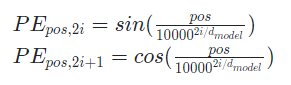

In [20]:
#torch.unsqueeze(input, dim)
#torch.unsqueeze(-1)

x = torch.tensor([1, 2, 3, 4])
print(x.unsqueeze(0))
print(x.unsqueeze(1))

tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])


In [23]:
#positional Encoding example

max_len = 10
d_model = 6

pe_ex = torch.zeros(max_len, d_model)
print(pe_ex) #10행*6열

position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
print("position", position)
#거듭 제곱 계산 pow()
#torch.arange(start, end, step) => (0, 512, 2)

div_term = torch.pow(10000, torch.arange(0,d_model,2).float()/d_model)

pe_ex[:, 0::2] = torch.sin(position / div_term)
pe_ex[:, 1::2] = torch.cos(position / div_term)

print(div_term)
print(pe_ex)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
position tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])
tensor([  1.0000,  21.5443, 464.1590])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7

In [25]:
pe_ex = torch.zeros(max_len, 1, d_model) #6*1*10개
print(pe_ex)

tensor([[[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.]]])


In [26]:
class PositionalEncoding(nn.Module): #embeded 된 input에 고정된 위치정보 값을 더해주는 모듈

    #d_model : input feature의 dimension
    #max_len : 들어올 수 있는 input 최대 길이
    
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term) #짝수일 경우, sin
        pe[:, 0, 1::2] = torch.cos(position * div_term) #홀수일 경우, cos
        self.register_buffer('pe', pe)
        #register_buffer(name, tensor) : optimizer가 업데이트 X, 값은 존재, GPU 연산 가능, state_dict()로 확인 가능
        #torch.nn.Module.register_buffer는 매개변수로 간주되지 않는 버퍼를 등록하는데 사용
        #즉, 네트워크 구성에 있어 중간에 업데이트를 하지 않는 일반 layer를 넣고 싶을 때 사용

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Transformer Encoder Layer

class TransformerEncoderLayer(Module):
    
    def __init__(self, 
                 d_model, #512
                 nhead,   #8
                 dim_feedforward=2048, 
                 dropout=0.1, 
                 activation="relu"):
        
        super(TransformerEncoderLayer, self).__init__()
        
        #Multi-head Attention : positional encoding이 완료된 embeded input을 받아서 self-attention 수행
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        
        # Implementation of Feedforward model
        # attention layer 이후에 residual connection + dropout
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)
        #d_model => dim_feedforward => d_model
        
        #LayerNorm() 통해 d_model 차원의 data에 대해 layer Normalization over a mini-batch
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def forward(self, 
                src: Tensor, 
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2) # 1.
        src = self.norm1(src) # 2.
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src)))) # 3.
        src = src + self.dropout2(src2) # 4-1.
        src = self.norm2(src) # 4-2.
        return src

## MultiheadAttention(d_model, nhead, dropout)

class MultiheadAttention(nn.Module):

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        
        # *3 : Query, Key, Value
        self.in_proj_weight = Parameter(torch.empty(3 * embed_dim, embed_dim))
        	
        #register_parameter() : Add a parameter to the module
        
        self.register_parameter('q_proj_weight', None)
        self.register_parameter('k_proj_weight', None)
        self.register_parameter('v_proj_weight', None)
        self.register_parameter('in_proj_bias', None) #input
            
        self.out_proj = _LinearWithBias(embed_dim, embed_dim) #output, embed_dim = num_heads
        self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn
        self._reset_parameters()

    def _reset_parameters(self):
    
        # 가중치 초기값을 적절하게 조정하면 모델의 성능이 증가
        # 초기값 uniform 방법 중 하나인 xavier
        
        xavier_uniform_(self.in_proj_weight)

	def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):

        return F.multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask)

In [37]:
#F.multi_head_attention_forward

def multi_head_attention_forward(query,                           # type: Tensor
                                 key,                             # type: Tensor
                                 value,                           # type: Tensor
                                 embed_dim_to_check,              # type: int
                                 num_heads,                       # type: int
                                 in_proj_weight,                  # type: Tensor
                                 in_proj_bias,                    # type: Tensor
                                 bias_k,                          # type: Optional[Tensor]
                                 bias_v,                          # type: Optional[Tensor]
                                 add_zero_attn,                   # type: bool
                                 dropout_p,                       # type: float
                                 out_proj_weight,                 # type: Tensor
                                 out_proj_bias,                   # type: Tensor
                                 training=True,                   # type: bool
                                 key_padding_mask=None,           # type: Optional[Tensor]
                                 need_weights=True,               # type: bool
                                 attn_mask=None,                  # type: Optional[Tensor]
                                 use_separate_proj_weight=False,  # type: bool
                                 q_proj_weight=None,              # type: Optional[Tensor]
                                 k_proj_weight=None,              # type: Optional[Tensor]
                                 v_proj_weight=None,              # type: Optional[Tensor]
                                 static_k=None,                   # type: Optional[Tensor]
                                 static_v=None                    # type: Optional[Tensor]
                                 ):
    
  	# tgt_len = Input에 몇 개의 문장이 들어왔는지
    # bsz = 각 문장에 단어가 몇 개인지
    # embed_dim = 각 단어가 크기 몇으로 벡터화됬는지
    
    tgt_len, bsz, embed_dim = query.size()
    
    # 멀티 헤드 어텐션을 사용하기 때문에 embed_dim은 head_dim * head 수
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5
    
    # (하나의 문장, 최대 단어 길이가 10, embed_dim이 5)라고 query를 가정했을 때,
    # query의 shape는 (1,10,5) 라고 볼 수 있다. 
    # 앞서 in_proj_weight의 dimension을 (3*embed_dim,embed_dim)으로 정해놓았기 때문에,
    # nn.linear 함수의 (x*A^T) 매트릭스 연산을 수행하면 (1,10,15)의 형태가 된다.  
    # q,k,v의 dimension이 모두 동일하다고 가정하였기 때문에 단순히 chunck함수를 사용해서 3등분 해주면
    # q,k,v가 각각 (1,10,5)의 크기가 된다?
    
    q, k, v = linear(query, in_proj_weight, in_proj_bias).chunk(3, dim=-1)
    q = q * scaling
    
    # tensor는 is_contiguous() 한 상태에서만 view나 transpose를 적용할 수 있다.
    # multihead attention이 뭔가 initialize를 여러 번하면서 loop를 도는 구조로 생각했었는데
    # initialize는 한 번만 하고 embed_dim을 여러개로 쪼개서 작업되는 것이었다.
    
    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)

    src_len = k.size(1)

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        attn_mask = pad(attn_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2))

    if attn_mask is not None:
        attn_output_weights += attn_mask

    attn_output_weights = softmax(
        attn_output_weights, dim=-1)
    attn_output_weights = dropout(attn_output_weights, p=dropout_p, training=training)

    attn_output = torch.bmm(attn_output_weights, v)
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output = linear(attn_output, out_proj_weight, out_proj_bias)

    return attn_output, None

In [22]:
#pip install torchdata

vocab 객체는 훈련 데이터셋에 의해 만들어지고, token을 tensor로 수치화하는데 사용

batchify() : 데이터를 batch_size column으로 정렬

ex) 26개의 알파벳을 batch_size = 4라고 한다면 => 길이가 6인 4개의 sequence로 나뉨

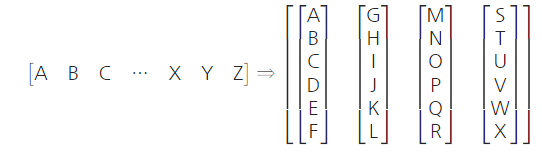

In [30]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer # 어떤 방식으로 numericalize할지 정의
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')      #데이터 split
tokenizer = get_tokenizer('basic_english') #tokenizer
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>']) #iterator에서 vocab build
#torchtext.vocab.build_vocab_from_iterator(iterator(vocab 빌드하는데 사용되는 iterator), min_freq(어휘에 토큰을 포함하는데 필요한 최소 빈도))

vocab.set_default_index(vocab['<unk>']) #index 처리

#IterableDataset : 학습데이터가 메모리에 다 올라가지 않는 경우 발생 해결 방안 중 하나
def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor.""" #raw  => flat Tensor 변환
    
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data))) #torch.numel(input) : 입력 텐서의 총 요소 수를 반환
    #filter() : 데이터의 행 추출

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2() #train, val, text 데이터 셋 분리
#각 데이터 tensor 형태로 변환 - data_process 함수 통해
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#batchify의 input으로 들어가는 data.examples[0].text 단어 단위로 쪼개져있는 문장들의 집합
def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz #bsz = 배치 사이즈
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20 #batch_size = 20으로 나누어 각 문장이 최대 단어 20개로 이루어지도록 데이터셋을 가공

eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [32]:
print(train_data.size())
print(val_data.size())
print(test_data.size())

torch.Size([102499, 20])
torch.Size([21441, 10])
torch.Size([24185, 10])


In [41]:
len(train_data)

102499

In [38]:
bptt = 35

#get_batch : 입력-타겟 sequence 쌍을 생성
#bptt 길이를 가진 덩어리로 세분화

def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1) #target은 data가 하나씩 shift된 데이터
    return data, target

In [39]:
ntokens = len(vocab) # 단어 사전(어휘집)의 크기
emsize = 200 # 임베딩 차원
d_hid = 200 # nn.TransformerEncoder 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # nn.TransformerEncoder 내부의 nn.TransformerEncoderLayer 개수 (num_layers)
nhead = 2 # nn.MultiheadAttention의 헤드 개수
dropout = 0.2 # 드랍아웃(dropout) 확률
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [42]:
import copy
import time

criterion = nn.CrossEntropyLoss() #cross EntropyLoss와 SGD 함께 사용
lr = 5.0  # 학습률(learning rate)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

#learning rate scheduler===================================================
#StepLR : 일정한 step마다 learning rate에 gamma를 곱해주는 방식
#==========================================================================
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # 학습 모드 시작
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        
        #get_batch : 입력-타겟 sequence 쌍을 생성
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # 마지막 배치에만 적용
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        #torch.nn.utils.clip_grad_norm()을 통해 gradient exploding 발생 금지
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            #StepLR : get_last_lr() : last compute learning rate by current scheduler
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

            
#평가
def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # 평가 모드 시작
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [43]:
best_val_loss = float('inf')
epochs = 3
best_model = None

for epoch in range(1, epochs + 1): #epoch 내에서 반복
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    #validation loss가 관찰한 것 중에 최적이라면 모델을 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 351.54 | loss  8.13 | ppl  3390.15
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 347.06 | loss  6.89 | ppl   977.62
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 345.75 | loss  6.45 | ppl   631.65
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 344.04 | loss  6.30 | ppl   544.02
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 343.68 | loss  6.18 | ppl   483.70
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 341.45 | loss  6.15 | ppl   468.04
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 345.22 | loss  6.11 | ppl   451.17
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 346.07 | loss  6.11 | ppl   451.92
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 350.26 | loss  6.02 | ppl   411.13
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 351.92 | loss  6.02 | ppl   410.02
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 348.90 | loss  5.89 | ppl   362.88
| epoch   

In [44]:
#평가

test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89) #===============================표시
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.52 | test ppl   248.39
